# Project objective

A stock picking is the key aspect of active investment portfolio management. There are numbers of investment strategies and different approaches on how to pick the right stock, well documented in the financial world, however, the main objective of this project is to utilise various unsupervised machine learning clustering techniques applied to stock market historical returns data, over the given period, to come up with new toolset as an addition to traditional portfolio management approach. 

# Brief dataset description

Stock Market data was downloaded from Yahoo Finance portal. Selection includes top 50 companies based on their percentage weight of widely-known S&P 500 index, as of 26th of May 2022. As a basis of the further calculations, Adjusted Close Price was extracted, using dedicated API. Period covered was 3 last years, from 1st of May 2019 to 30th of April 2022. Full list of selected stock tickers was included in appendix section.

# Data import

## Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


## Yahoo Finance data import

To extract required data from Yahoo finance, the below function will be used:

In [2]:
def get_details(tickers):
    names = {}
    sectors = {}
    for ticker in tickers:
        try:
            name = yf.Ticker(ticker).info['longName'] ## get full ticker name
            names[ticker] = name
            sector = yf.Ticker(ticker).info['sector'] ## get sector of the ticker
            sectors[ticker] = sector
            #print(f'{ticker} completed')
        except KeyError:
            names[ticker] = 'no_data'
            sectors[ticker] = 'no_data'
    return names, sectors

The list of S&P500 top 50 companies (as of 26th of May 2022) has been created:

In [3]:
string =  "AAPL MSFT AMZN GOOGL GOOG TSLA BRK-B UNH JNJ NVDA \
           META XOM JPM PG V CVX HD PFE MA ABBV BAC KO LLY PEP \
           MRK AVGO VZ TMO COST ABT CMCSA ADBE DIS CSCO MCD \
           ACN WMT WFC INTC BMY PM LIN AMD TXN DHR CRM T QCOM \
           COP NEE" 

In [4]:
tickers = list(string.split())
len(tickers)

50

In [5]:
names, sectors = get_details(tickers)

In [6]:
## Workaround fix for FB/META - sector missing from .info
names['META'] = yf.Ticker('META').info['longName']
sectors['META'] = 'Communication Services'

names['WFC'] = yf.Ticker('WFC').info['longName']
sectors['WFC'] = 'Financial Services'

In [7]:
data = yf.download(tickers, start="2019-05-01", end="2022-04-30")

[*********************100%***********************]  50 of 50 completed


In [8]:
data.head(5)

Adj Close                                                \
                 AAPL       ABBV        ABT         ACN        ADBE   
Date                                                                  
2019-04-30  49.055115  67.970139  76.269257  176.371811  289.250000   
2019-05-01  51.463013  67.542068  75.483177  175.058701  283.350006   
2019-05-02  51.128105  67.182487  75.521523  173.204910  279.640015   
2019-05-03  51.763695  67.387955  75.435249  170.877975  285.579987   
2019-05-06  50.964329  67.858841  75.799522  170.182831  283.660004   

                                                                    ...  \
                  AMD       AMZN        AVGO        BAC        BMY  ...   
Date                                                                ...   
2019-04-30  27.629999  96.325996  291.278564  28.574995  42.541103  ...   
2019-05-01  26.809999  95.575996  291.735931  28.275980  42.678543  ...   
2019-05-02  28.290001  95.041000  288.918304  28.500242  42.953411  ...   
2019-05-03  28.219999  98.123001  288.817657  28.696474  44.547672  ...   
2019-05-06  27.420000  97.527496  285.030304  28.472208  44.071228  ...   

              Volume                                                  \
                   T      TMO       TSLA      TXN      UNH         V   
Date                                                                   
2019-04-30  46341721  1380700   47323000  4533200  7632300   6432700   
2019-05-01  35810228  1491900   53522000  3335800  4823200   5248100   
2019-05-02  39338026  1353800   90796500  4532200  5499200   6054900   
2019-05-03  37370694  1254200  118534000  3689000  4323100   4317500   
2019-05-06  33340968  1320300   54169500  3974300  7180200  10442400   

                                                   
                  VZ       WFC      WMT       XOM  
Date                                               
2019-04-30  15469000  18525100  6133600  13721500  
2019-05-01  11627400  17542100  5337200  13909800  
2019-05-02  14435400  16883000  5007000  15360400  
2019-05-03   9388200  16571300  5316900  12180700  
2019-05-06  10066100  19279900  4613700  13367100  

[5 rows x 300 columns]

For the project pursposes, all features except *Adjusted close price* will be removed. Adjusted close price is a stock's closing price amended for corporate actions, such as dividends, stock splits, rights offering, etc.

In [9]:
df = data['Adj Close']

In [10]:
df.head(5)

,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,BAC,BMY,...,T,TMO,TSLA,TXN,UNH,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-30,49.055115,67.970139,76.269257,176.371811,289.250000,27.629999,96.325996,291.278564,28.574995,42.541103,...,17.782404,275.705505,47.737999,110.288712,223.205429,161.409821,50.727638,44.342102,98.116684,66.836189
2019-05-01,51.463013,67.542068,75.483177,175.058701,283.350006,26.809999,95.575996,291.735931,28.275980,42.678543,...,17.684763,274.751495,46.801998,108.847290,222.132828,159.799942,50.133339,44.177235,96.704674,65.495796
2019-05-02,51.128105,67.182487,75.521523,173.204910,279.640015,28.290001,95.041000,288.918304,28.500242,42.953411,...,17.587120,276.063171,48.820000,109.942398,222.611679,158.160599,50.550236,44.241344,96.504318,64.346909
2019-05-03,51.763695,67.387955,75.435249,170.877975,285.579987,28.219999,98.123001,288.817657,28.696474,44.547672,...,17.633072,276.888031,51.006001,110.677307,222.132828,159.063721,50.771980,44.561943,97.391609,64.496765
2019-05-06,50.964329,67.858841,75.799522,170.182831,283.660004,27.420000,97.527496,285.030304,28.472208,44.071228,...,17.569891,277.205994,51.068001,109.160385,230.320984,159.299316,50.479267,44.360424,97.754150,64.213692


There are no blank values in the dataset

In [11]:
df.isnull().values.any()

False

# Exploratory Data Analysis

Based on Exploratory Data Analysis performed on the dataset, it was identified that there are no blank values. All weekends and holidays were taken into account when extracting the data, hence no approach to handle missing data was required. 

As a key step in the analysis, two new features were created, based on the price of individual security: 


Simple return, is calculated as per below:

$\Large R_t=\frac{P_t-P_{t-1}}{P_{t-1}}$
    
    
Log return based on the following formula:

$\Large R_t = \frac{\log(P_t)}{\log(P_{t-1})}$

Where **P** is a price of our stock, and **t** is a time period

Simple/ log return values replaced the Adjusted Price values, for the individual company: 

In [12]:
df_simple_rtn = (df - df.shift(1)) / df.shift(1)
df_simple_rtn = df_simple_rtn.iloc[1: , :].fillna(0)

df_log_rtn = np.log(df) - np.log(df.shift(1))
df_log_rtn = df_log_rtn.iloc[1: , :].fillna(0)

df_simple_rtn

,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,BAC,BMY,...,T,TMO,TSLA,TXN,UNH,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.049086,-0.006298,-0.010307,-0.007445,-0.020398,-0.029678,-0.007786,0.001570,-0.010464,0.003231,...,-0.005491,-0.003460,-0.019607,-0.013070,-0.004805,-0.009974,-0.011715,-0.003718,-0.014391,-0.020055
2019-05-02,-0.006508,-0.005324,0.000508,-0.010590,-0.013093,0.055203,-0.005598,-0.009658,0.007931,0.006440,...,-0.005521,0.004774,0.043118,0.010061,0.002156,-0.010259,0.008316,0.001451,-0.002072,-0.017541
2019-05-03,0.012431,0.003058,-0.001142,-0.013435,0.021241,-0.002474,0.032428,-0.000348,0.006885,0.037116,...,0.002613,0.002988,0.044777,0.006684,-0.002151,0.005710,0.004387,0.007247,0.009194,0.002329
2019-05-06,-0.015443,0.006988,0.004829,-0.004068,-0.006723,-0.028349,-0.006069,-0.013113,-0.007815,-0.010695,...,-0.003583,0.001148,0.001216,-0.013706,0.036862,0.001481,-0.005765,-0.004522,0.003723,-0.004389
2019-05-07,-0.026957,-0.016528,-0.027317,-0.013163,-0.023232,-0.027717,-0.015150,-0.013737,-0.018050,-0.018295,...,-0.001962,-0.026025,-0.032427,-0.016658,-0.010187,-0.012756,-0.004920,-0.026017,-0.011321,-0.005315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.006737,0.008452,0.003093,0.019369,0.012920,0.028931,0.011943,0.001584,-0.007189,0.003960,...,-0.000512,-0.030502,-0.006995,0.003462,0.006392,0.008551,-0.031401,-0.011006,0.000510,-0.033713
2022-04-26,-0.037328,-0.000768,-0.025331,-0.043305,-0.035826,-0.060977,-0.045751,-0.047306,-0.022526,-0.006049,...,-0.010764,-0.050941,-0.121841,-0.031453,-0.020009,-0.042153,-0.017303,-0.027275,-0.010450,0.000365
2022-04-27,-0.001467,0.009220,-0.002137,0.000000,-0.003057,-0.002936,-0.008781,-0.000946,-0.005487,0.002910,...,-0.011917,0.007823,0.005808,0.005640,0.000058,0.064694,-0.019227,0.000000,-0.006825,0.028558


In [13]:
df_log_rtn

,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,BAC,BMY,...,T,TMO,TSLA,TXN,UNH,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.047919,-0.006318,-0.010360,-0.007473,-0.020608,-0.030127,-0.007817,0.001569,-0.010519,0.003226,...,-0.005506,-0.003466,-0.019802,-0.013156,-0.004817,-0.010024,-0.011785,-0.003725,-0.014496,-0.020259
2019-05-02,-0.006529,-0.005338,0.000508,-0.010646,-0.013180,0.053733,-0.005613,-0.009705,0.007900,0.006420,...,-0.005537,0.004763,0.042214,0.010011,0.002153,-0.010312,0.008281,0.001450,-0.002074,-0.017697
2019-05-03,0.012355,0.003054,-0.001143,-0.013526,0.021019,-0.002477,0.031913,-0.000348,0.006862,0.036444,...,0.002609,0.002983,0.043803,0.006662,-0.002153,0.005694,0.004377,0.007220,0.009152,0.002326
2019-05-06,-0.015563,0.006963,0.004817,-0.004076,-0.006746,-0.028758,-0.006087,-0.013200,-0.007846,-0.010753,...,-0.003590,0.001148,0.001215,-0.013801,0.036198,0.001480,-0.005782,-0.004532,0.003716,-0.004399
2019-05-07,-0.027327,-0.016666,-0.027697,-0.013250,-0.023506,-0.028108,-0.015265,-0.013832,-0.018215,-0.018465,...,-0.001964,-0.026370,-0.032965,-0.016798,-0.010239,-0.012838,-0.004932,-0.026361,-0.011386,-0.005330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.006715,0.008417,0.003088,0.019184,0.012837,0.028521,0.011872,0.001583,-0.007214,0.003953,...,-0.000512,-0.030977,-0.007019,0.003456,0.006372,0.008514,-0.031904,-0.011067,0.000510,-0.034294
2022-04-26,-0.038043,-0.000768,-0.025658,-0.044271,-0.036483,-0.062915,-0.046830,-0.048461,-0.022784,-0.006067,...,-0.010822,-0.052284,-0.129928,-0.031958,-0.020212,-0.043067,-0.017455,-0.027654,-0.010505,0.000365
2022-04-27,-0.001468,0.009178,-0.002140,0.000000,-0.003061,-0.002940,-0.008820,-0.000947,-0.005502,0.002906,...,-0.011989,0.007792,0.005791,0.005624,0.000058,0.062688,-0.019414,0.000000,-0.006849,0.028157


Looking at histograms of log return of individual companies for the period appears to be normally distributed:

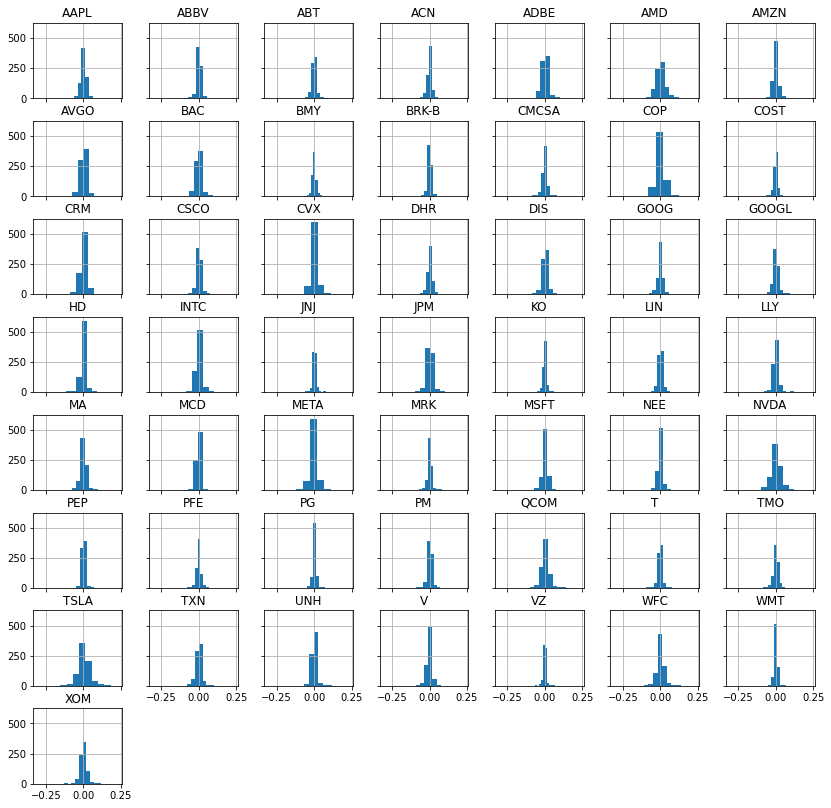

In [14]:
plt.rcParams['figure.figsize'] = [14, 14]
df_log_rtn.hist(sharex=True, sharey=True)
plt.show()

<AxesSubplot:title={'center':'Total return density'}, ylabel='Density'>

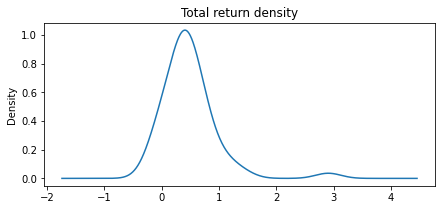

In [15]:
plt.rcParams['figure.figsize'] = [7, 3]
df_log_rtn.sum().plot.density(title='Total return density')

General return rate of individual stocks was presented below. As per the below, top 1 company’s (Tesla) return rate was roughly twice as big as the second company’s (NVIDIA) return rate during the given period.

<AxesSubplot:title={'center':'Total return per ticker'}>

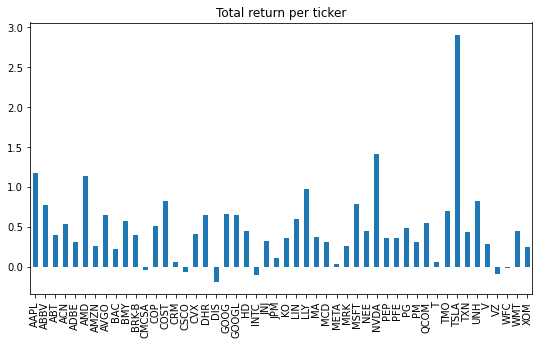

In [16]:
plt.rcParams['figure.figsize'] = [9, 5]
df_log_rtn.sum().plot.bar(title='Total return per ticker')

Daily returns over relevant period were presented below. It can be observed that the most volatile period occurred between Feb’2022 and April 2022, probably due to start of the Covid-19 pandemic

[Text(0.5, 1.0, 'Return over time')]

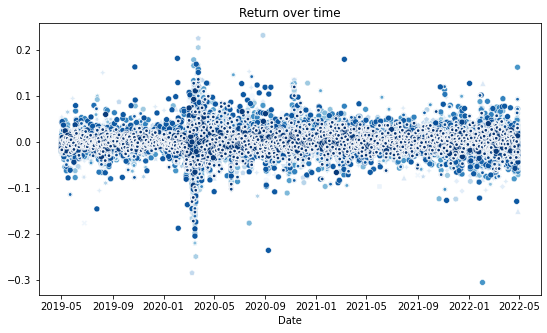

In [17]:
sns.scatterplot(data=df_log_rtn, legend=False, palette='Blues').set(title='Return over time')

In [18]:
df_simple_rtn.describe().T

,count,mean,std,min,25%,50%,75%,max
AAPL,757.0,0.001777,0.021630,-0.128647,-0.008240,0.001097,0.013432,0.119808
ABBV,757.0,0.001176,0.017570,-0.162524,-0.007052,0.001567,0.009351,0.087174
ABT,757.0,0.000687,0.017985,-0.097856,-0.007510,0.001119,0.009351,0.109360
ACN,757.0,0.000879,0.018769,-0.083899,-0.007253,0.001747,0.009258,0.128573
ADBE,757.0,0.000696,0.023680,-0.147452,-0.009911,0.002098,0.012643,0.177193
AMD,757.0,0.002042,0.033244,-0.146390,-0.015873,0.000588,0.020283,0.165016
AMZN,757.0,0.000553,0.020776,-0.140494,-0.009447,0.000782,0.010746,0.135359
AVGO,757.0,0.001151,0.024351,-0.199129,-0.010200,0.001778,0.013514,0.158337
BAC,757.0,0.000610,0.025221,-0.153974,-0.010482,0.000714,0.012618,0.177962
BMY,757.0,0.000863,0.014757,-0.074179,-0.006801,0.000963,0.008105,0.068419


For the modeling purposes, as well as to present the results, DataFrame including simple returns has been transposed:

In [19]:
df_return_T = df_simple_rtn.T

df_return_T.columns = df_return_T.columns.astype(str)

df_results = df_return_T[[]].join(pd.Series(names, name='Company name'),how='left')
df_results = df_results.join(pd.Series(sectors, name='Sector'),how='left')

There are 9 individuals sectors relevant to previously mentioned top 50 S&P companies:

<AxesSubplot:ylabel='Sector'>

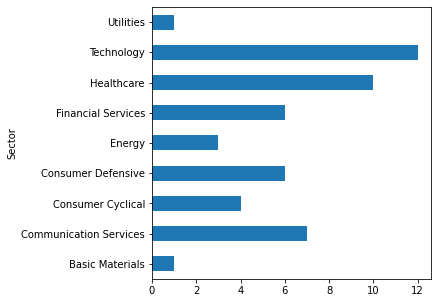

In [20]:
plt.rcParams['figure.figsize'] = [5, 5]
df_results.groupby(['Sector']).count().plot.barh(legend=False)

# Unsupervised learning models

As mentioned in the objective section, the main goal was to group 50 top stocks into smaller clusters, based on their daily simple return for last 3 years, in order to enhance future stock selection, supported by the on various fundamental analysis criteria. To achieve that, 3 individual unsupervised machine learning models were introduced:

* Model A – K-Means
* Model B – Agglomerative clustering
* Model C – DBSCAN

In order to standardize the models parameters, required number of clusters was determined per inertia criteria. Per the elbow method, it was decided to use 4 individual clusters for model A, and model B respectively. For DBSCAN, parameters of ε = 0.7 and minimum samples of 3 were defined per Grid Search results.

## Model A: K-Means

A basic clustering algorithm, where the cluster centers are found based on minimized squared error between each point of the data and their cluster center

In order to standardize the models parameters, required number of clusters was determined per inertia criteria. Per the elbow method, it was decided to use 4 individual clusters for model A,

In [21]:
km_list = []
for clust in range(1,20):
    km = KMeans(n_clusters=clust, random_state=34)
    km = km.fit(df_return_T)
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

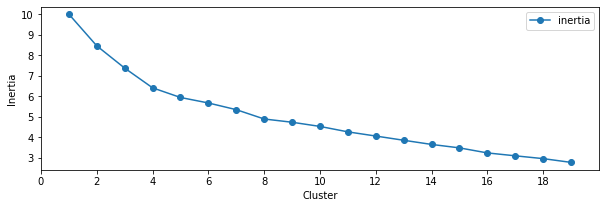

In [22]:
plt.rcParams['figure.figsize'] = [10, 3]
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o', ls='-')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0,20)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

In [23]:
km = KMeans(n_clusters=4, random_state=42)
km = km.fit(df_return_T)

df_return_T['kmeans'] = km.predict(df_return_T)

In [24]:
df_results[['kmeans']] = df_return_T[['kmeans']]

Each company has been alocated to one of four clusters (kmeans column). Results are presented below

In [25]:
df_results

,Company name,Sector,kmeans
AAPL,Apple Inc.,Technology,1
ABBV,AbbVie Inc.,Healthcare,0
ABT,Abbott Laboratories,Healthcare,0
ACN,Accenture plc,Technology,0
ADBE,Adobe Inc.,Technology,1
AMD,"Advanced Micro Devices, Inc.",Technology,1
AMZN,"Amazon.com, Inc.",Consumer Cyclical,1
AVGO,Broadcom Inc.,Technology,1
BAC,Bank of America Corporation,Financial Services,3
BMY,Bristol-Myers Squibb Company,Healthcare,0


Also, results broken down per the sector:

In [26]:
df_results[['kmeans','Sector']].groupby(['Sector','kmeans']).size().to_frame().rename(columns={0:'companies #'})

companies #
Sector                 kmeans             
Basic Materials        0                 1
Communication Services 0                 4
                       1                 3
Consumer Cyclical      0                 2
                       1                 2
Consumer Defensive     0                 6
Energy                 2                 3
Financial Services     0                 3
                       3                 3
Healthcare             0                10
Technology             0                 2
                       1                10
Utilities              0                 1

## Model B: Agglomerative Clustering

Agglomerative clustering algorithm is a type of hierarchical clustering, where each observation begins with its own cluster, then the clusters are merged subsequently, based on specific linkage criteria.

In [27]:
from sklearn.cluster import AgglomerativeClustering
### BEGIN SOLUTION
ag = AgglomerativeClustering(n_clusters=4, linkage='ward', compute_full_tree=True)
ag = ag.fit(df_return_T)
df_results['agglom'] = ag.fit_predict(df_return_T)

In [28]:
df_results.groupby(['agglom', df_return_T.index]).sum()

kmeans
agglom              
0      AAPL        1
       ADBE        1
       AMD         1
       AMZN        1
       AVGO        1
       CRM         1
       GOOG        1
       GOOGL       1
       INTC        1
       META        1
       MSFT        1
       NVDA        1
       QCOM        1
       TSLA        1
       TXN         1
1      ABBV        0
       ABT         0
       ACN         0
       BMY         0
       BRK-B       0
       CMCSA       0
       COST        0
       CSCO        0
       DHR         0
       DIS         0
       HD          0
       JNJ         0
       KO          0
       LIN         0
       LLY         0
       MA          0
       MCD         0
       MRK         0
       NEE         0
       PEP         0
       PFE         0
       PG          0
       PM          0
       T           0
       TMO         0
       UNH         0
       V           0
       VZ          0
       WMT         0
2      COP         2
       CVX         2
       XOM         2
3      BAC         3
       JPM         3
       WFC         3

## Model C: DBSCAN

Density-based Spatial Clustering of Applications with Noise. Based on the number of points in space, the points are grouped together based in the areas of high density. The algorithm requires two parameters: **minimum number of samples** and **epsilon**, which defines density criteria, and unlike the other two algorithms, it is able to identify outliers

In [29]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.7, min_samples=3)
db = db.fit(df_return_T)
df_results['dbscan'] = db.fit_predict(df_return_T)
                                      

Interestingly, DBSCAN algorithm allocated Tesla stock as an outlier.

In [30]:
df_results.groupby(['dbscan', df_return_T.index]).sum()

kmeans  agglom
dbscan                      
-1     TSLA        1       0
 0     AAPL        1       0
       ADBE        1       0
       AMD         1       0
       AMZN        1       0
       AVGO        1       0
       CRM         1       0
       GOOG        1       0
       GOOGL       1       0
       INTC        1       0
       META        1       0
       MSFT        1       0
       NVDA        1       0
       QCOM        1       0
       TXN         1       0
 1     ABBV        0       1
       ABT         0       1
       ACN         0       1
       BMY         0       1
       BRK-B       0       1
       CMCSA       0       1
       COST        0       1
       CSCO        0       1
       DHR         0       1
       DIS         0       1
       HD          0       1
       JNJ         0       1
       KO          0       1
       LIN         0       1
       LLY         0       1
       MA          0       1
       MCD         0       1
       MRK         0       1
       NEE         0       1
       PEP         0       1
       PFE         0       1
       PG          0       1
       PM          0       1
       T           0       1
       TMO         0       1
       UNH         0       1
       V           0       1
       VZ          0       1
       WMT         0       1
 2     BAC         3       3
       JPM         3       3
       WFC         3       3
 3     COP         2       2
       CVX         2       2
       XOM         2       2

## Model Summary

Due to the nature of unsupervised models, the evaluation of specific model performance can be difficult. The key assumption taken was, the individual stocks that belong to the same sector, should generally have similar returns, therefore the more consistent labeling into individual sectors, the more accurately the model works.

Per the table below, it can be observed that all 3 models were quite consistent results:

In [31]:
df_results.groupby(['Sector','kmeans','agglom','dbscan']).size().to_frame().rename(columns={0:'companies #'})

companies #
Sector                 kmeans agglom dbscan             
Basic Materials        0      1       1                1
Communication Services 0      1       1                4
                       1      0       0                3
Consumer Cyclical      0      1       1                2
                       1      0      -1                1
                                      0                1
Consumer Defensive     0      1       1                6
Energy                 2      2       3                3
Financial Services     0      1       1                3
                       3      3       2                3
Healthcare             0      1       1               10
Technology             0      1       1                2
                       1      0       0               10
Utilities              0      1       1                1

As mentioned in the above paragraph, all three models tend to perform similarly, however taking into consideration the simplicity, the final unsupervised model suggested for application is Model A, based on K-Means algorithm. It is recommended due to its interpretability, also being the general purpose model, which works well when applying clustering to daily returns, and it is also relatively low-cost when it comes to the computations.

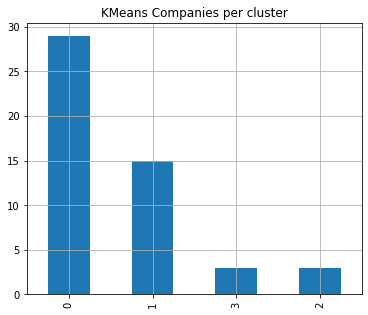

In [32]:
plt.rcParams['figure.figsize'] = [6, 5]

df_results['kmeans'].value_counts().plot.bar(title="KMeans Companies per cluster", grid=True)
plt.show()

# Further recommendations 

Clusters created by unsupervised model could be an introduction to standard portfolio management approaches and fundamental analysis. The clusters created by K-Means model can be used for selection of stocks for to enhance portfolio diversification, not only based on the sector, but also on daily returns. 

It is worth to mention that all developed models based only on daily returns feature, therefore the next step recommended is also to include additional variables, such as volatility (measured by standard deviation) or daily volume.

# Appendix

In [33]:
df_results

,Company name,Sector,kmeans,agglom,dbscan
AAPL,Apple Inc.,Technology,1,0,0
ABBV,AbbVie Inc.,Healthcare,0,1,1
ABT,Abbott Laboratories,Healthcare,0,1,1
ACN,Accenture plc,Technology,0,1,1
ADBE,Adobe Inc.,Technology,1,0,0
AMD,"Advanced Micro Devices, Inc.",Technology,1,0,0
AMZN,"Amazon.com, Inc.",Consumer Cyclical,1,0,0
AVGO,Broadcom Inc.,Technology,1,0,0
BAC,Bank of America Corporation,Financial Services,3,3,2
BMY,Bristol-Myers Squibb Company,Healthcare,0,1,1
